# Cleaning experiments

## Doubtlab experiment 

**Dataset:** synthetic binary with 30% noisy labels as proposed by Juan Roman

Lucas de A Oliveira / Q3 2022

---

### Code for dataset and basic functions

(Juan Roman)

In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

from src.app.util.dataset_cartography_gbdt import dataset_cartography, plot_dataset_cartography
from src.app.util.cleaning_datasets_threshold import search_inconsistent_neighbors

from melitk.melipass import get_secret
import os
import re
import s3fs

import pandas as pd
import numpy as np
import lightgbm as lgbm
import seaborn as sns
import pickle
from tqdm import tqdm

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix,  average_precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics

import session_info
session_info.show(html=False)

-----
lightgbm            3.3.2
matplotlib          3.5.3
melitk              NA
numpy               1.23.2
pandas              1.4.4
s3fs                2022.8.2
seaborn             0.11.2
session_info        1.0.0
sklearn             1.1.2
src                 NA
tqdm                4.64.0
-----
IPython             8.4.0
jupyter_client      7.3.5
jupyter_core        4.11.1
jupyterlab          1.2.6
notebook            6.4.12
-----
Python 3.8.6 (default, Apr 11 2022, 15:35:21) [GCC 9.3.0]
Linux-5.4.0-1024-aws-x86_64-with-glibc2.2.5
-----
Session information updated at 2022-09-13 16:24


In [3]:
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs

In [4]:
SEED = 42

/root/.cache/pypoetry/virtualenvs/app-BNAhPZAj-py3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

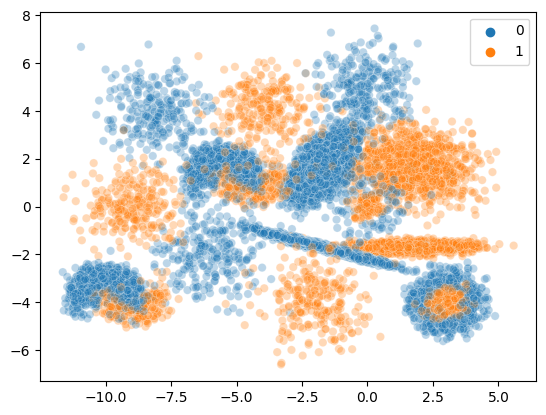

In [5]:
X_list = []
y_list = []

X, y = make_classification(n_samples=10000, n_redundant=0,weights=(0.8,),
                           class_sep=1.7,n_classes=2,
                           n_features=2, n_informative=2, random_state=12, n_clusters_per_class=2)
X_list.append(X)
y_list.append(y)

X1, y1 = make_circles(n_samples= 200, noise=0.3, factor=0.1, random_state=31)
X1 = X1 + np.array([[0,0]])
X_list.append(X1)
y_list.append(y1)

X2,y2 = make_moons((1000,200), noise=0.3, random_state=31)
X2 = X2 + np.array([[-5.5,1]])
X_list.append(X2)
y_list.append(y2)


X3,y3 = make_blobs(n_samples=500, centers=[(-6,-2),(-4,4)], cluster_std=[1,1])
X_list.append(X3)
y_list.append(y3)


X4,y4 = make_blobs(n_samples=500, centers=[(-8,4),(-2,-4)], cluster_std=[1,1])
X_list.append(X4)
y_list.append(y4)


X5,y5 = make_blobs(n_samples=500, centers=[(0,5),(-9,0)], cluster_std=[0.9,1])
X_list.append(X5)
y_list.append(y5)

X6, y6 = make_circles(n_samples= 1000, noise=0.3, factor=0.1, random_state=31)
X6 = X6 + np.array([[3,-4]])
X_list.append(X6)
y_list.append(y6)

X7,y7 = make_moons((1000,200), noise=0.3, random_state=31)
X7 = X7 + np.array([[-10,-4]])
X_list.append(X7)
y_list.append(y7)

#X6,y6 = make_blobs(n_samples=500, centers=[(-9,0),(0,5)], cluster_std=[0.9,1])
#X_list.append(X6)
#y_list.append(y6)


X = np.concatenate(X_list)
y = np.concatenate(y_list)

sns.scatterplot(X[:,0],X[:,1], hue= y, alpha=0.3)

Original class distribution:
0    0.749801
1    0.250199
Name: label, dtype: float64
true_zero      0.523907
label_noise    0.300000
true_one       0.176093
Name: tag, dtype: float64


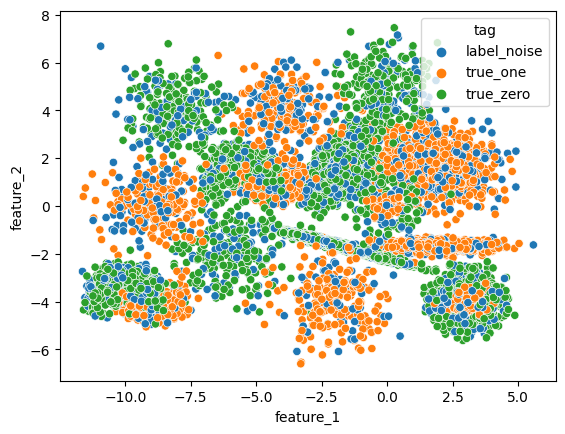

In [6]:
def make_dataframe(X,y,misslabeled_frac = 0.1, plot_flag = False, SEED=None):
    df = pd.DataFrame(np.column_stack((X,y)), columns=["feature_1", "feature_2","label"])
    df.loc[:,"label"] = df.loc[:,"label"].astype(int)
    print(f"Original class distribution:\n{ df.loc[:,'label'].value_counts(1) }")
    mask = df['label']==1
    df.loc[mask,'tag'] = "true_one"
    df.loc[~mask,'tag'] = "true_zero"
    misslabeled  = df.sample(frac=misslabeled_frac,random_state=SEED)
    df.loc[misslabeled.index,"label"] = misslabeled['label'].add(-1).abs()
    df.loc[misslabeled.index,"tag"] = "label_noise"
    print(df.loc[:,"tag"].value_counts(1))
    if plot_flag:
        sns.scatterplot(x='feature_1', y='feature_2', hue='tag', data=df,)
    return df
    
df = make_dataframe(X,y,misslabeled_frac = 0.3, plot_flag = True,SEED=31) 

In [7]:
df.head()

,feature_1,feature_2,label,tag
0,-1.358819,2.086186,1,label_noise
1,3.258744,2.508539,1,true_one
2,-2.756971,-1.292928,0,true_zero
3,2.987981,-1.591824,0,label_noise
4,2.289680,-1.799912,1,true_one


In [8]:
def plot_clf_boundaries(clf,X_test,y_test,grid_resolution =50, ax=None):

    if not ax:
        fig, ax= plt.subplots()
        
    (x0_min, x1_min) = np.min(X_test)
    (x0_max, x1_max) = np.max(X_test)

    xx0, xx1 = np.meshgrid(
                np.linspace(x0_min, x0_max, grid_resolution),
                np.linspace(x1_min, x1_max, grid_resolution),
            )

    X_grid = np.c_[xx0.ravel(), xx1.ravel()]
    y_grid_pred_proba = clf.predict_proba(X_grid)[:,1]
    contours = ax.contourf(xx0,xx1,y_grid_pred_proba.reshape(xx0.shape), 10, cmap='RdBu_r', alpha=0.7)
    plt.colorbar(contours, ax=ax)

    ax.scatter(X_test.iloc[:,0],X_test.iloc[:,1],c=df.loc[y_test.index,'label'], cmap='RdBu_r', marker='+', alpha=0.5)

def plot_clf(clf,X_test,y_test, th=0.5):

    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2, figsize=(15,10))
    metrics.RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax1)
    metrics.PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, ax=ax1)
    metrics.plot_confusion_matrix(clf, X_test,y_test, ax=ax4)

    y_pred_proba = clf.predict_proba(X_test)[:,1]
    for _class in np.unique(y_test):
        mask = y_test == _class
        #ax3.hist(y_pred_proba[mask], label=_class, bins=100, alpha=0.5, density=True)
        sns.kdeplot(y_pred_proba[mask], label=_class, ax=ax3)

    ax3.legend()

    print(metrics.classification_report(y_test,y_pred_proba>th))
    plot_clf_boundaries(clf,X_test,y_test, grid_resolution =100, ax=ax2)

Test without noise metrics
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1199
           1       0.74      0.91      0.82       356

    accuracy                           0.91      1555
   macro avg       0.86      0.91      0.88      1555
weighted avg       0.92      0.91      0.91      1555



/root/.cache/pypoetry/virtualenvs/app-BNAhPZAj-py3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/root/.cache/pypoetry/virtualenvs/app-BNAhPZAj-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/root/.cache/pypoetry/virtualenvs/app-BNAhPZAj-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain t

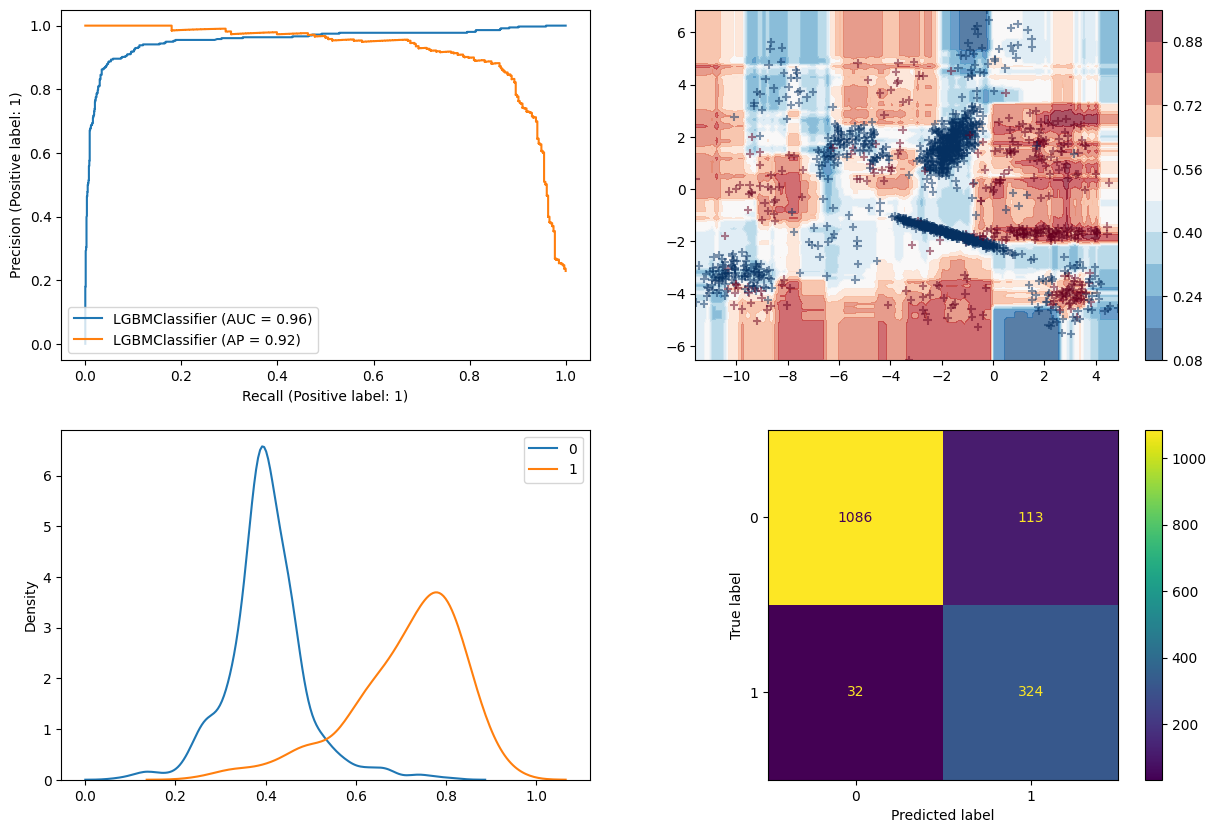

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:2],df.loc[:,"label"], test_size=0.15, random_state=20181209)
clf = lgbm.LGBMClassifier(is_unbalance=True, random_state=20181209)
clf.fit(X_train, y_train)
mask = df.loc[X_test.index,'tag']!= 'label_noise'
print(f"Test without noise metrics")
plot_clf(clf,X_test[mask],y_test[mask])

---

### Dataset cartography method + decision tree weights

(Moacir A Ponti)

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 15 µs


100%|██████████| 100/100 [00:00<00:00, 109.27it/s]


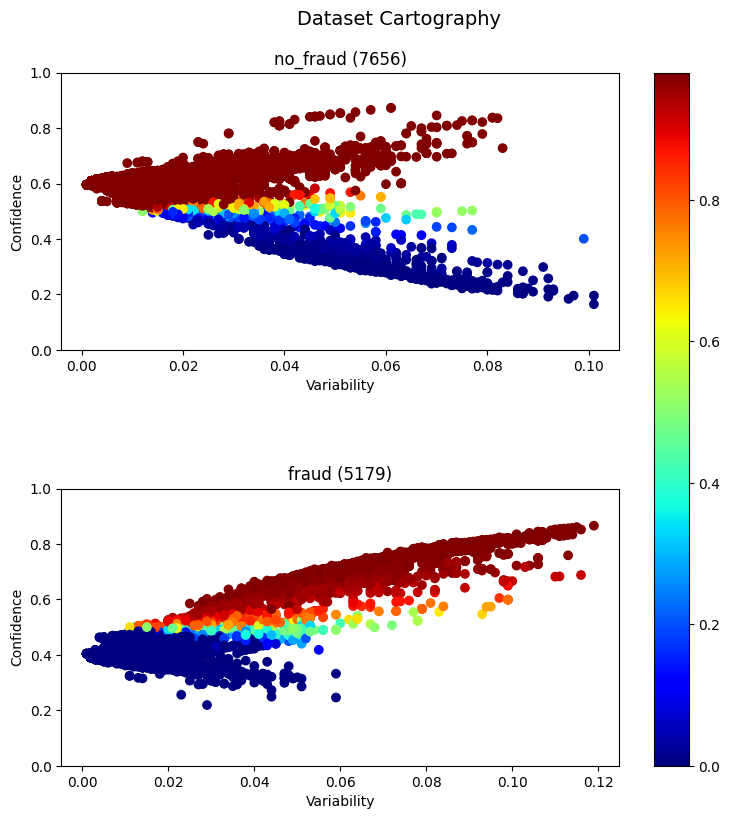

In [10]:
%time
dic_classes = {'no_fraud':0, 'fraud':1}
confid1, variab1, correc1 = dataset_cartography(clf, X_train, y_train.astype(int),range_estimators=[0,100])
plot_dataset_cartography(confid1, variab1, correc1, y_train, dic_classes, subplot_size=(2,1))

In [11]:
def calculate_metrics_from_prediciton(y_true,y_pred_prob, threshold = 0.5):
    y_pred = (y_pred_prob > threshold).astype(int)
    
    mcc = metrics.matthews_corrcoef(y_true, y_pred)
    precision, recall, thresholds = metrics.precision_recall_curve(y_true,y_pred_prob)
    pr_auc = metrics.auc(recall, precision)
    precision = metrics.precision_score(y_true,y_pred,zero_division=0)
    recall = metrics.recall_score(y_true,y_pred,zero_division=0)
    f1 = metrics.f1_score(y_true,y_pred,zero_division=0)
    classification_report = metrics.classification_report(y_true, y_pred,zero_division=0)
    
    return {'mcc':mcc , 'pr_auc': pr_auc, 'f1':f1, 'precision':precision, 'recall':recall, 'classification_report':classification_report,'threshold':threshold}

def calculate_metrics(clf, X,y, threshold = 0.5):
    from sklearn import metrics
    
    y_pred_prob = clf.predict_proba(X)[:,1]
    y_pred = (y_pred_prob > threshold).astype(int)
    
    mcc = metrics.matthews_corrcoef(y, y_pred)
    precision, recall, thresholds = metrics.precision_recall_curve(y,y_pred_prob)
    pr_auc = metrics.auc(recall, precision)
    precision = metrics.precision_score(y,y_pred,zero_division=0)
    recall = metrics.recall_score(y,y_pred,zero_division=0)
    f1 = metrics.f1_score(y,y_pred,zero_division=0)
    classification_report = metrics.classification_report(y, y_pred,zero_division=0)
    
    return {'mcc':mcc , 'pr_auc': pr_auc, 'f1':f1, 'precision':precision, 'recall':recall, 'classification_report':classification_report,'threshold':threshold}

def run_experiment(df,X_train,y_train, X_test,y_test,EPOCHS = 100):
    
    # initial weights initialization
    weights = np.ones_like(y_train)
    # Noise reference
    y_true_noise = (df.loc[X_train.index,"tag"] == 'label_noise').astype(int)
    # weight correction steps
    step = 1/EPOCHS
    
    #result container
    result = dict(
                weights_list = [],
                confidence_list = [],
                correctness_list = [],
                clf_list = [],
                metrics_list = [],
                noise_metrics_list = [],
                tag = df.loc[X_train.index,"tag"]
                )
    
    # weight correction iteration
    for i in range(EPOCHS):
        
        #fit using weights
        clf = lgbm.LGBMClassifier(random_state=SEED, is_unbalance=True)
        clf.fit(X_train, y_train, sample_weight=weights)
        
        confid, variab, correc = dataset_cartography(clf, X_train, y_train,range_estimators=[0,100])
        
        result["weights_list"].append(weights)
        result["confidence_list"].append(confid)
        result["correctness_list"].append(correc)
        result["clf_list"].append(clf)
        mask = df.loc[X_test.index,'tag']!= 'label_noise'
        result["metrics_list"].append(calculate_metrics(clf,X_test[mask],y_test[mask]))
        
        #Noise metrics
        y_pred_proba = 1 - weights
        result["noise_metrics_list"].append(calculate_metrics_from_prediciton(y_true_noise,y_pred_proba,threshold=0.5))
        
        #weigts correction
        weights  = np.clip( weights - step*(1 - correc*confid), 0,1)
        
    return result.copy()

def plot_result(result,METRIC_NAME = 'f1'):

    fig ,axes = plt.subplots(ncols=5, figsize=(25,5))
    pd.DataFrame(result['metrics_list'])[METRIC_NAME].rolling(3).mean().plot(ax=axes[0])
    axes[0].set_title(f"{METRIC_NAME} evolution in Test set without noise")
    axes[0].set_xlabel(f"iteration")

    pd.DataFrame(result['noise_metrics_list'] )[METRIC_NAME].rolling(3).mean().plot(ax=axes[1])
    axes[1].set_title(f"{METRIC_NAME} evolution for label noise detection")
    axes[1].set_xlabel(f"iteration")

    temp_df = df.loc[X_train.index,:].copy()
    temp_df['w'] =result['weights_list'][-1]

    sns.kdeplot(x='w', data=temp_df,  hue='tag',ax=axes[2])
    axes[2].set_xlabel(f"weights")
    axes[2].set_title(f"weights distributions by tag")


    sns.violinplot(x='tag',y='w', data=temp_df, ax=axes[3])
    axes[3].set_title(f"weights distributions by tag")
    axes[3].set_ylabel(f"weights")


    iteration = sum([list(np.ones_like(w)*i) for i,w in enumerate(result['weights_list'])]  ,[])
    w = np.asarray(result['weights_list']).ravel()
    tags = np.asarray([result['tag'].values]*len(result['weights_list'])).ravel()
    temp_df = pd.DataFrame({'iteration':iteration, 'w':w,'tags':tags})
    temp_df['iteration'] = temp_df['iteration'].astype(int)
    sns.boxplot(x='iteration', y='w', hue='tags', data=temp_df, showfliers=False, ax=axes[4])
    axes[3].set_title(f"weights progression")

100%|██████████| 100/100 [00:00<00:00, 109.29it/s]


CPU times: user 4min 51s, sys: 3.89 s, total: 4min 55s
Wall time: 14.1 s


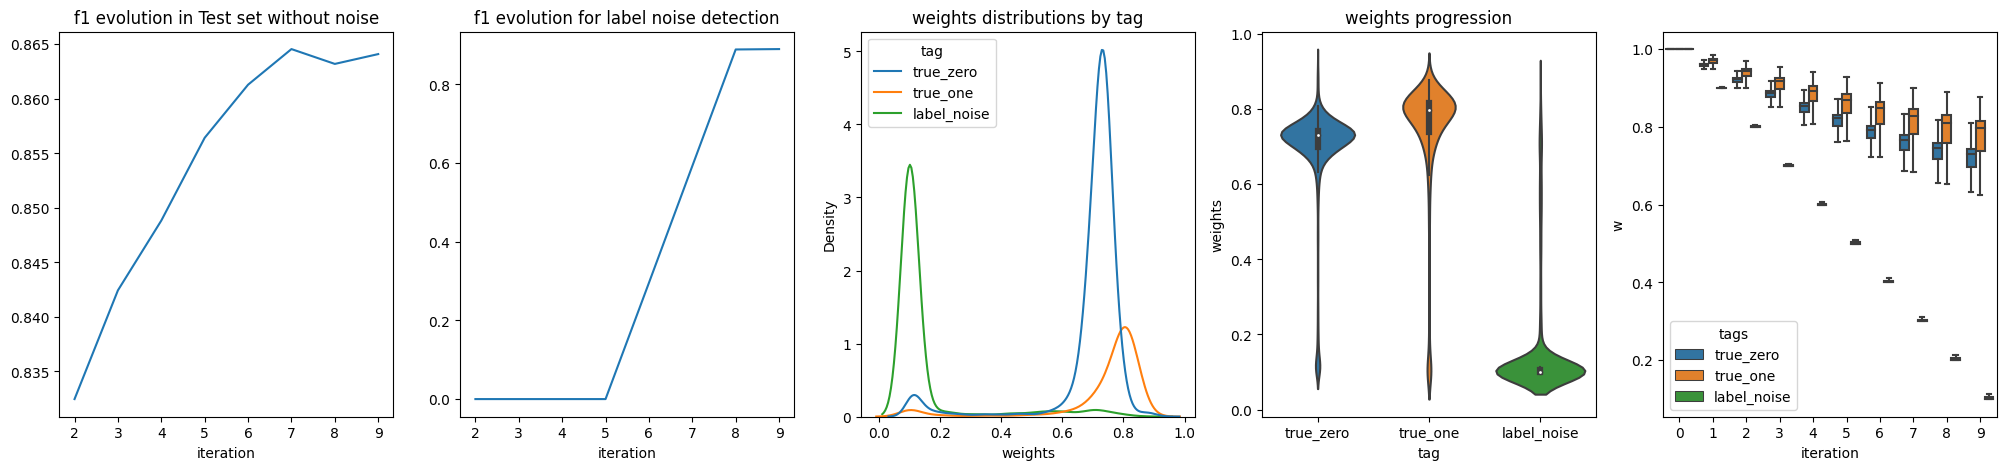

In [12]:
%%time
result = run_experiment(df,X_train,y_train, X_test,y_test,EPOCHS = 10)
plot_result(result,METRIC_NAME = 'f1')

In [13]:
noisy_items = df.loc[X_train.index,'tag'] == 'label_noise'

In [14]:
noisy_cartography = result['weights_list'][-1] < 0.2

In [15]:
true_noisy_cartography = sum(noisy_cartography==noisy_items) / len(noisy_items)

false_noisy_cartography = sum(noisy_cartography & ~noisy_items) / sum(~noisy_items)
not_detected_noisy_cartography = sum(~noisy_cartography & noisy_items) / sum(noisy_items)

In [16]:
print(f'Accuracy true noisy items: {true_noisy_cartography*100:.2f}%')
print(f'Not detected true noisy items: {not_detected_noisy_cartography*100:.2f}%')
print(f'Error related to false noisy items detected: {false_noisy_cartography*100:.2f}%')

Accuracy true noisy items: 93.32%
Not detected true noisy items: 11.57%
Error related to false noisy items detected: 4.60%


---

### Method based on hard threshold

(Moacir A Ponti)

In [17]:
low_quality = (correc1*confid1) < 0.2

In [18]:
true_noisy_cartonn = sum(low_quality == noisy_items) / len(noisy_items)

false_noisy_cartonn = sum(low_quality & ~noisy_items) / sum(~noisy_items)
not_detected_noisy_cartonn = sum(~low_quality & noisy_items) / sum(noisy_items)

In [19]:
print('Cartography with hard threshold')
print(f'Accuracy true noisy items: {true_noisy_cartonn*100:.2f}%')
print(f'Not detected true noisy items: {not_detected_noisy_cartonn*100:.2f}%')
print(f'Error related to false noisy items detected: {false_noisy_cartonn*100:.2f}%')

Cartography with hard threshold
Accuracy true noisy items: 92.69%
Not detected true noisy items: 12.28%
Error related to false noisy items detected: 5.20%


---

### Doubtlab - Doubt Ensemble

In [46]:
from doubtlab.ensemble import DoubtEnsemble
from doubtlab.reason import ProbaReason, ShortConfidenceReason, LongConfidenceReason, OutlierReason, CleanlabReason, DisagreeReason, RandomReason

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [21]:
clf1 = lgbm.LGBMClassifier(random_state=SEED, is_unbalance=True)
clf1.fit(X_train, y_train)

LGBMClassifier(is_unbalance=True, random_state=42)

In [22]:
# Another model to use on DisagreeReason
clf2 = SVC(random_state=SEED, probability=True)
clf2.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [53]:
# Another model to use on DisagreeReason
clf3 = LogisticRegression(random_state=SEED, class_weight='balanced')
clf3.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

- LGBM and SVM

In [64]:
ensemble = DoubtEnsemble(
    proba=ProbaReason(clf1),
    cleanlab=CleanlabReason(clf1),
    short = ShortConfidenceReason(clf1, threshold=0.05),
    long = LongConfidenceReason(clf1, threshold=0.95),
    disagree=DisagreeReason(clf1, clf2)
)

In [65]:
# Get the predicates, or reasoning, behind the order
predicates = ensemble.get_predicates(X_train, y_train)

In [66]:
predicates["sum_reasons"] = predicates.sum(axis=1)

In [67]:
predicates.sort_index(inplace=True)

In [68]:
for n_min_reason in [1, 2, 3, 4, 5]:
    
    print("="*100)
    print(f"N min reason = {n_min_reason}")
    predicates["tag_doubt_noise"] = np.where(predicates["sum_reasons"]>=n_min_reason, True, False)

    true_noisy_doubtlab = sum(predicates['tag_doubt_noise'].values==noisy_items) / len(noisy_items)

    false_noisy_doubtlab = sum(predicates['tag_doubt_noise'].values & ~noisy_items) / sum(~noisy_items)
    not_detected_noisy_doubtlab = sum(~predicates['tag_doubt_noise'].values & noisy_items) / sum(noisy_items)

    print(f'Accuracy true noisy items: {true_noisy_doubtlab*100:.2f}%')
    print(f'Not detected true noisy items: {not_detected_noisy_doubtlab*100:.2f}%')
    print(f'Error related to false noisy items detected: {false_noisy_doubtlab*100:.2f}%')

N min reason = 1
Accuracy true noisy items: 83.80%
Not detected true noisy items: 3.30%
Error related to false noisy items detected: 21.66%
N min reason = 2
Accuracy true noisy items: 71.05%
Not detected true noisy items: 84.95%
Error related to false noisy items detected: 5.22%
N min reason = 3
Accuracy true noisy items: 69.31%
Not detected true noisy items: 99.50%
Error related to false noisy items detected: 1.53%
N min reason = 4
Accuracy true noisy items: 70.24%
Not detected true noisy items: 100.00%
Error related to false noisy items detected: 0.00%
N min reason = 5
Accuracy true noisy items: 70.24%
Not detected true noisy items: 100.00%
Error related to false noisy items detected: 0.00%


- LGBM and Logistic Regresion

In [59]:
ensemble = DoubtEnsemble(
    proba=ProbaReason(clf1),
    cleanlab=CleanlabReason(clf1),
    short = ShortConfidenceReason(clf1, threshold=0.05),
    long = LongConfidenceReason(clf1, threshold=0.95),
    disagree=DisagreeReason(clf1, clf3)
)

In [60]:
# Get the predicates, or reasoning, behind the order
predicates = ensemble.get_predicates(X_train, y_train)

In [61]:
predicates["sum_reasons"] = predicates.sum(axis=1)

In [62]:
predicates.sort_index(inplace=True)

In [63]:
for n_min_reason in [1, 2, 3, 4, 5]:
    
    print("="*100)
    print(f"N min reason = {n_min_reason}")
    predicates["tag_doubt_noise"] = np.where(predicates["sum_reasons"]>=n_min_reason, True, False)

    true_noisy_doubtlab = sum(predicates['tag_doubt_noise'].values==noisy_items) / len(noisy_items)

    false_noisy_doubtlab = sum(predicates['tag_doubt_noise'].values & ~noisy_items) / sum(~noisy_items)
    not_detected_noisy_doubtlab = sum(~predicates['tag_doubt_noise'].values & noisy_items) / sum(noisy_items)

    print(f'Accuracy true noisy items: {true_noisy_doubtlab*100:.2f}%')
    print(f'Not detected true noisy items: {not_detected_noisy_doubtlab*100:.2f}%')
    print(f'Error related to false noisy items detected: {false_noisy_doubtlab*100:.2f}%')

N min reason = 1
Accuracy true noisy items: 69.61%
Not detected true noisy items: 3.56%
Error related to false noisy items detected: 41.76%
N min reason = 2
Accuracy true noisy items: 76.32%
Not detected true noisy items: 63.12%
Error related to false noisy items detected: 6.97%
N min reason = 3
Accuracy true noisy items: 69.55%
Not detected true noisy items: 98.80%
Error related to false noisy items detected: 1.49%
N min reason = 4
Accuracy true noisy items: 70.24%
Not detected true noisy items: 100.00%
Error related to false noisy items detected: 0.00%
N min reason = 5
Accuracy true noisy items: 70.24%
Not detected true noisy items: 100.00%
Error related to false noisy items detected: 0.00%


- SVM and Logistic Regresion

In [69]:
ensemble = DoubtEnsemble(
    proba=ProbaReason(clf2),
    cleanlab=CleanlabReason(clf2),
    short = ShortConfidenceReason(clf2, threshold=0.05),
    long = LongConfidenceReason(clf2, threshold=0.95),
    disagree=DisagreeReason(clf2, clf3)
)

In [70]:
# Get the predicates, or reasoning, behind the order
predicates = ensemble.get_predicates(X_train, y_train)

In [71]:
predicates["sum_reasons"] = predicates.sum(axis=1)

In [72]:
predicates.sort_index(inplace=True)

In [73]:
for n_min_reason in [1, 2, 3, 4, 5]:
    
    print("="*100)
    print(f"N min reason = {n_min_reason}")
    predicates["tag_doubt_noise"] = np.where(predicates["sum_reasons"]>=n_min_reason, True, False)

    true_noisy_doubtlab = sum(predicates['tag_doubt_noise'].values==noisy_items) / len(noisy_items)

    false_noisy_doubtlab = sum(predicates['tag_doubt_noise'].values & ~noisy_items) / sum(~noisy_items)
    not_detected_noisy_doubtlab = sum(~predicates['tag_doubt_noise'].values & noisy_items) / sum(noisy_items)

    print(f'Accuracy true noisy items: {true_noisy_doubtlab*100:.2f}%')
    print(f'Not detected true noisy items: {not_detected_noisy_doubtlab*100:.2f}%')
    print(f'Error related to false noisy items detected: {false_noisy_doubtlab*100:.2f}%')

N min reason = 1
Accuracy true noisy items: 71.82%
Not detected true noisy items: 6.54%
Error related to false noisy items detected: 37.35%
N min reason = 2
Accuracy true noisy items: 76.08%
Not detected true noisy items: 71.60%
Error related to false noisy items detected: 3.72%
N min reason = 3
Accuracy true noisy items: 70.36%
Not detected true noisy items: 99.53%
Error related to false noisy items detected: 0.02%
N min reason = 4
Accuracy true noisy items: 70.24%
Not detected true noisy items: 100.00%
Error related to false noisy items detected: 0.00%
N min reason = 5
Accuracy true noisy items: 70.24%
Not detected true noisy items: 100.00%
Error related to false noisy items detected: 0.00%
